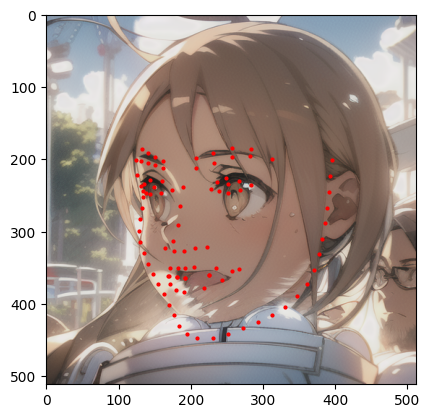

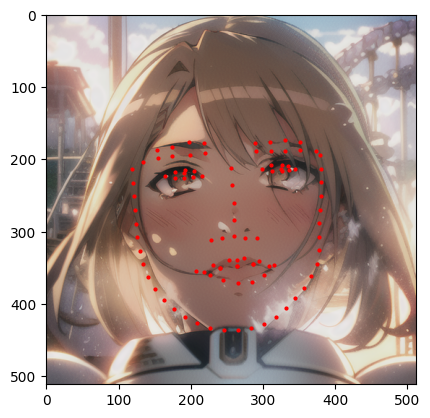

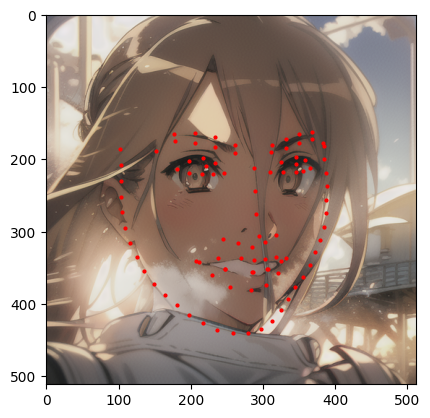

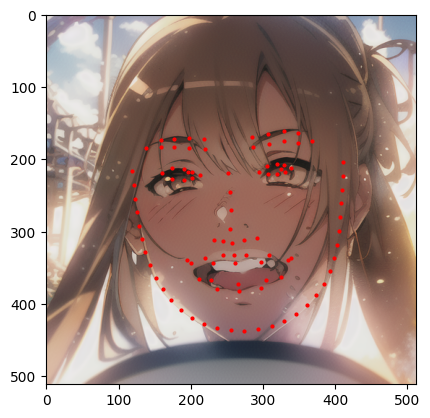

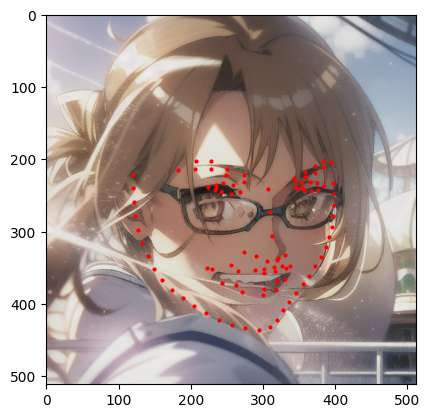

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import webuiapi
import csv


# WFLWのアノテーションデータの読み込み
annotation_data_path = "/root/dataset/WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
WFLW_images = "/root/dataset/WFLW/WFLW_images"
# prompts = [
#     "1girl,face,beautiful,masterpiece,anime,cute",
#     # "1girl,masterpiece,anime,cute,best quality, highly detailed,face,beautiful",
#     "1boy,face,beautiful,masterpiece,anime,cool,detailed,insanely detailed","nose",
#     # "1boy,face,beautiful,masterpiece,anime,cute,ultra detailed",
#     "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,flat color",
#     "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,line art",
#     # "1girl,face,beautiful,masterpiece,anime,cute,red eyes,insanely detailed,highly detailed,flat color,simple",
# ]
# negative_prompt = "lowres, (worst quality:1.5), (low quality:1.5), normal quality, text, watermark"



image_save_path = "/root/dataset/generated_images_dataset/image"
annotation_save_path = "/root/dataset/generated_images_dataset/annotations"

api = webuiapi.WebUIApi(host='10.8.76.222', port=7860) # control_image

with open(annotation_data_path) as f:
    anotation_data = f.readlines()
anotation_data_lists = []
for i in anotation_data:
    anotation_data_lists.append(i.split(" "))
    
# image_num = 1
for image_num in range(0,5):
    # 入力画像の加工-------------------------------------------------------------------------------------------
    image_name = anotation_data_lists[image_num][-1].replace("\n","")
    # print(image_name)
    image_path = WFLW_images + "/" + image_name
    bounding_box_data = tuple([int(bdbox) for bdbox in anotation_data_lists[image_num][-11:-7]])
    # fig, ax = plt.subplots(1)
    image = Image.open(image_path)
    # 顔画像のバウンディングボックスのサイズ
    face_width = bounding_box_data[2]-bounding_box_data[0]
    face_height = bounding_box_data[3]-bounding_box_data[1]
    # print(face_width)
    # print(face_height)
    #顔の中心座標
    face_center_x = float((bounding_box_data[2]+bounding_box_data[0]) / 2)
    face_center_y = float((bounding_box_data[3]+bounding_box_data[1]) / 2)
    # print("face_center",face_center_x,face_center_y)

    # クロップサイズの決定
    margin = float((face_width+face_height) / 2 * 0.2)
    half_long_side = max(face_width,face_height) / 2
    image_size = margin + half_long_side
    # print("image_size:",image_size)
    crop_size = (
        face_center_x-image_size,
        face_center_y-image_size,
        face_center_x+image_size,
        face_center_y+image_size
    )
    # print(crop_size)
    control_image = image.crop(crop_size)
    # ax.imshow(control_image)

    # ランドマーク座標の加工-------------------------------------------------------------------------------------------
    crop_keypoints_x = [float(keypoint) - crop_size[0] for keypoint in anotation_data_lists[image_num][0:196:2]]
    crop_keypoints_y = [float(keypoint) - crop_size[1] for keypoint in anotation_data_lists[image_num][1:196:2]]
    # print("bounding_box_data",bounding_box_data)
    x_np = np.array(crop_keypoints_x)
    y_np = np.array(crop_keypoints_y)
    
    # 生成画像のランドマーク用意
    genimage_keypoints_x = [float(keypoint_x * (512 / (image_size*2))) for keypoint_x in crop_keypoints_x]
    genimage_keypoints_y = [float(keypoint_y * (512 / (image_size*2))) for keypoint_y in crop_keypoints_y]
    x_np = np.array(genimage_keypoints_x)
    y_np = np.array(genimage_keypoints_y)
    # print(x_np[0:10])
    # print(y_np[0:10])
    
    prompts = [
        "1girl, low ponytail, no wind, messy hair, best brown girl hair, outdoors, white shorts, amusement park,casualty, depth of field, best quality, aesthetic, detailed, best quality, anime screencap, aesthetic, volumetric lighting, created by Artgerm, photography, masterpiece, clean face, realistic, beautiful, view from below"
    ]
    negative_prompt = "young age, child, blur, poorly drawn face, disfigured, weak colors, extra fingers, (low quality, worst quality:1.3), deformed face"
    
    # イラスト生成
    unit1 = webuiapi.ControlNetUnit(
            input_image=control_image,
            module='openpose_faceonly',
            model='control_v11p_sd15_openpose [cab727d4]',
            weight=2
        )
    
    
    # fig, ax = plt.subplots(1)
    for num,prompt in enumerate(prompts):
        image_file_name = image_name.split("/")[1].replace(".jpg","")
        r = api.txt2img(
            prompt=prompt,
            negative_prompt=negative_prompt,
            width=512,
            height=512,
            steps=28,
            controlnet_units=[unit1]
        )       
        
        fig,ax = plt.subplots(1)
        ax.imshow(r.image)
        plt.plot(x_np, y_np, 'o',color='red',markersize=2)
        plt.show()
        # r.image.save(f"{image_save_path}/{image_file_name}_{num}.jpg")
        
        #アノテーションデータをcsvファイルに保存する
        # annotation_data_csv = [val for pair in zip(genimage_keypoints_x, genimage_keypoints_y) for val in pair]
        # annotation_data_csv.insert(0,f"{image_file_name}_{num}.jpg")
        
        # with open(f"{annotation_save_path}/annotations.csv","a") as f:
        #     writer = csv.writer(f)
        #     writer.writerow(annotation_data_csv)        
        